# Entendimiento de datos

**Conjunto de datos:** Dataset 2 - Lugares de emisiones

**Nombre de archivo:** emission_permits_anom_2.json

## 0. Inicialización

### 0.1. Perfilamiento de datos

Instalar ydata-profiling

In [1]:
!pip install ydata-profiling

Importaciones

In [5]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
from tabulate import tabulate

Visualización de tablas y gráficas

In [24]:
sns.set_style("darkgrid")

def print_table(df):
    print(tabulate(df, headers='keys', tablefmt='simple_outline'))

Lectura y muestra del archivo

In [11]:
# 1. Cargar el JSON
with open('../data/emission_permits_anom_2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. Extraer features
features = data['features']

# 3. Construir DataFrame con properties y coordenadas
df = pd.DataFrame([
    {
        **feature['properties'],
        'Latitud': feature['geometry']['coordinates'][1],
        'Longitud': feature['geometry']['coordinates'][0]
    }
    for feature in features
])

df.head()

,IDExpediente,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,Latitud,Longitud
0,73640.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,CENTRO,None,Otros,Horno,Río Bogotá,4.703418,-74.226561
1,73788.0,Seguimiento y Control,Ubate,Cundinamarca,LENGUAZAQUE,Resguardo,None,Carbón,Caldera Horno,Río Suárez,5.318407,-73.704281
2,74314.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,MADRID,LA PUNTA,None,ACPM,Caldera Horno,Río Bogotá,4.800462,-74.210355
3,75972.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,MOSQUERA,Balsillas,None,Fuel Oil No.8,Planta de Asfalto,Río Bogotá,4.678797,-74.284112
4,78824.0,Seguimiento y Control,Sabana Occidente,Cundinamarca,FUNZA,El Hato,None,Carbón,Caldera Horno,Río Bogotá,4.699590,-74.193752


Guardar el dataset completo en archivo más accesible

In [9]:
df.to_csv('../data/emission_permits_anom_2.csv', index=False, encoding='utf-8')

**Hallazgos:** Cada fila representa una fuente fija de emisión perteneciente a una empresa en la región central (Cundinamarca y Boyacá), que cuenta con un permiso ambiental para la liberación de contaminantes atmosféricos.

Cada fuente cuenta con:

- Identificador del expediente o trámite del permiso de emisión de contaminantes aéreos
- Estado del trámite / licencia
- Región administrativa de la Corporación Autónoma 
Regional (CAR)
- Departamento, municipio y vereda donde se ubica la fuente
- Clase de infracción cometida
- Tipo de combustible usado por la fuente
- Tipo de fuente
- Cuenca hidrográfica asociada al área de influencia
- Localización geográfica (latitud y longitud) de la fuente

Información del archivo (Cantidad de filas, cantidad de columnas y tipos de dato)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDExpediente       544 non-null    float64
 1   Estado             544 non-null    object 
 2   Regional           544 non-null    object 
 3   Departamento       544 non-null    object 
 4   Municipio          544 non-null    object 
 5   Vereda             544 non-null    object 
 6   Class              321 non-null    object 
 7   TipoCombustible    544 non-null    object 
 8   TipoFuenteEmision  544 non-null    object 
 9   Cuenca             544 non-null    object 
 10  Latitud            544 non-null    float64
 11  Longitud           544 non-null    float64
dtypes: float64(3), object(9)
memory usage: 51.1+ KB


Columnas agrupadas por tipo de dato

In [13]:
columnas_por_tipo = df.columns.to_series().groupby(df.dtypes).groups

print("Columnas agrupadas por tipo de dato:\n")
for tipo, cols in columnas_por_tipo.items():
    print(f"{tipo} ({len(cols)} columnas): {', '.join(cols)}")

Columnas agrupadas por tipo de dato:

float64 (3 columnas): IDExpediente, Latitud, Longitud
object (9 columnas): Estado, Regional, Departamento, Municipio, Vereda, Class, TipoCombustible, TipoFuenteEmision, Cuenca


**Hallazgos:**
- Solamente por tipo de dato, hay 9 variables categóricas (object) y 3 variables numéricas (int64 y float64)
- 1 en realidad es variable categórica, por lo que tenemos:
    - **10 variables categóricas:** IDExpediente, Estado, Regional, Departamento, Municipio, Vereda, Class, TipoCombustible, TipoFuenteEmision, Cuenca
    - **2 variables numéricas:** Latitud, Longitud
- Hay tipos de dato que probablemente no corresponden a los valores posibles de las columnas, por lo que estos problemas deben ser abordados. Esto ocurre para la columna `IDExpediente`, por lo que se propone cambiarla a int

### 0.2. Cambios sobre las columnas

Verificamos si esta columna puede ser convertida a int

In [14]:
puede_int = (df['IDExpediente'].dropna() % 1 == 0).all()
print(f"'IDExpediente': {'se puede convertir a int' if puede_int else 'mantener como float'}")

'IDExpediente': se puede convertir a int


Como sí puede serlo, ejecutamos el cambio

In [15]:
df['IDExpediente'] = df['IDExpediente'].astype("Int64")

## 1. Variables categóricas

Temporalmente, mapeamos las variables categóricas guardadas como número a texto

In [16]:
cols_otra_categoria = ['IDExpediente']

for col in cols_otra_categoria:
    df[f"{col}_obj"] = df[col].astype("object")

Variables categóricas encontradas

In [17]:
non_numeric_attributes = df.select_dtypes(exclude=['number']).columns.values
pd.DataFrame(non_numeric_attributes, columns=['Non Numeric Attributes'])

,Non Numeric Attributes
0,Estado
1,Regional
2,Departamento
3,Municipio
4,Vereda
5,Class
6,TipoCombustible
7,TipoFuenteEmision
8,Cuenca
9,IDExpediente_obj


Conteo de filas, cantidad de filas únicas, moda y su frecuencia

In [21]:
with pd.option_context('display.max_colwidth', None):
    display(df[non_numeric_attributes].describe())

,Estado,Regional,Departamento,Municipio,Vereda,Class,TipoCombustible,TipoFuenteEmision,Cuenca,IDExpediente_obj
count,544,544,544,544,544,321,544,544,544,544
unique,3,14,3,65,148,3,12,30,7,502
top,Sancionatorio,Sabana Centro,Cundinamarca,SOACHA,MOCHUELO BAJO,Por emisiones atmosféricas sin cumplir con los requisitos de ley,(sin definir),(sin definir),Río Bogotá,183556
freq,321,130,461,58,47,142,329,328,317,6


**Hallazgos:**

- Hay 3 estados, y el más común es Sancionatorio
- Hay 14 regionales, y la más común es Sabana Centro
- Hay 3 valores únicos en la columna `Departamento`, y el más común es Cundinamarca
- Hay 65 municipios, y el más común es Soacha
- Hay 148 veredas, y la más común es Mochuelo Bajo, ubicada en Ciudad Bolívar
- Hay 3 clases de infracciones, y la más común es 'Por emisiones atmosféricas sin cumplir con los requisitos de ley'
- Hay 12 tipos de combustible, y el valor más común es (sin definir).
- Hay 30 tipos de fuente, y el valor más común es (sin definir).
- Hay 7 cuencas, y la más común es el Río Bogotá
- Hay 502 expedientes, y el identificador más común es 183556 con 6 ocurrencias
- Hay problemas de completitud de datos en las columnas `TipoCombustible` y `TipoFuenteEmision`, al no tener definido su valor en algunas fuentes.
- Pueden haber problemas de duplicidad por la repetición del ID del expediente, pero lo más probable es que múltiples fuentes de emisión dentro de una misma empresa compartan un permiso ambiental.

Conteos y porcentajes para cada valor único en las columnas. 

In [25]:
for col in non_numeric_attributes:
    attribute = df[col].value_counts()
    df_attribute = pd.DataFrame({
        f"{col} values": attribute.index,
        'Count': attribute.values,
        'Percentage (%)': attribute.values * 100 / attribute.values.sum()
    }).sort_values(by='Count', ascending=False)

    print_table(df_attribute)

┌────┬───────────────────────┬─────────┬──────────────────┐
│    │ Estado values         │   Count │   Percentage (%) │
├────┼───────────────────────┼─────────┼──────────────────┤
│  0 │ Sancionatorio         │     321 │         59.0074  │
│  1 │ Seguimiento y Control │     216 │         39.7059  │
│  2 │ En Trámite            │       7 │          1.28676 │
└────┴───────────────────────┴─────────┴──────────────────┘
┌────┬───────────────────────────────────┬─────────┬──────────────────┐
│    │ Regional values                   │   Count │   Percentage (%) │
├────┼───────────────────────────────────┼─────────┼──────────────────┤
│  0 │ Sabana Centro                     │     130 │        23.8971   │
│  1 │ Ubate                             │     113 │        20.7721   │
│  2 │ Soacha                            │      72 │        13.2353   │
│  3 │ Bogotá y Municipio de la Calera   │      66 │        12.1324   │
│  4 │ Alto Magdalena                    │      37 │         6.80147  │
│  5

**Hallazgos:**

- Los 3 valores únicos de `Departamento` corresponden a Cundinamarca, Distrito Capital y Boyacá
- En `Municipio` hay 4 valores únicos que inician con 'LOCALIDAD DE'
- En `Municipio` hay un valor único 'LOC.USAQUEN CERROS ORIENTALES', que en realidad hace referencia a Usaquén
- No hay una capitalización estándar en `Vereda`
- En `TipoCombustible` hay valores de '(sin definir)', 'NoAplica' y 'Otros'
- En `TipoCombustible` hay un valor en inglés, 'Fuel Oil No.8'
- No hay una capitalización estándar en `TipoFuenteEmision`
- En `TipoFuenteEmision` hay valores de '(sin definir)' y 'NoAplica (área de operación)'
- En `TipoFuenteEmision` hay valores que hacen o podrían hacer referencia a lo mismo, como molino - Molino y TRITURADOR DE MATERIAL - TRITURADORA - Trituradora - PLANTA TRITURADORA
- En `Cuenca` hay valores de '(sin definir)'

Visualización de esta información con diagramas de conteos (diagramas de barras)

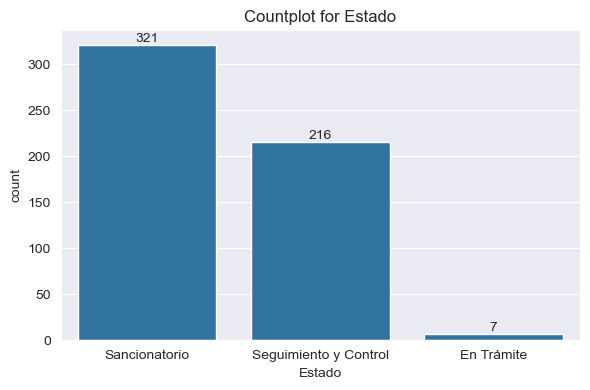

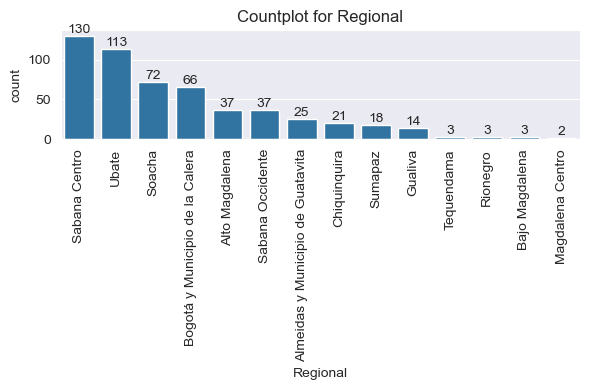

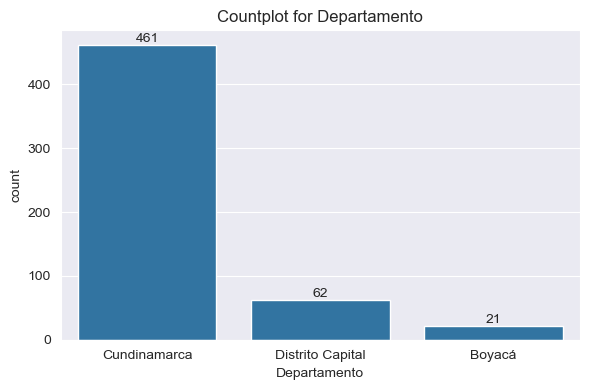

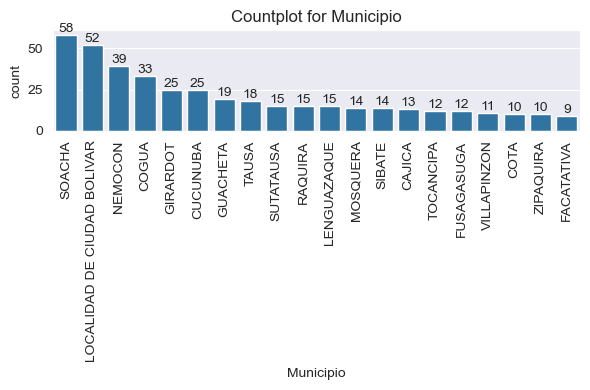

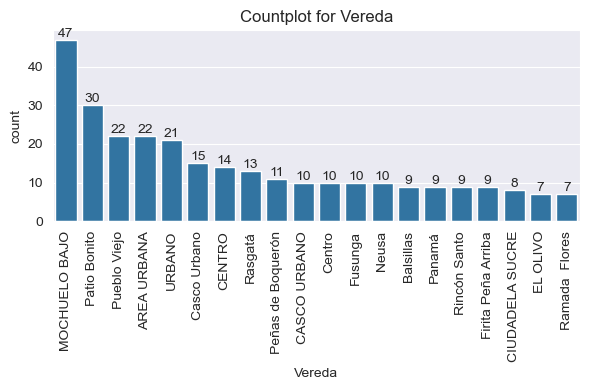

C:\Users\saras\AppData\Local\Temp\ipykernel_17996\4144202153.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


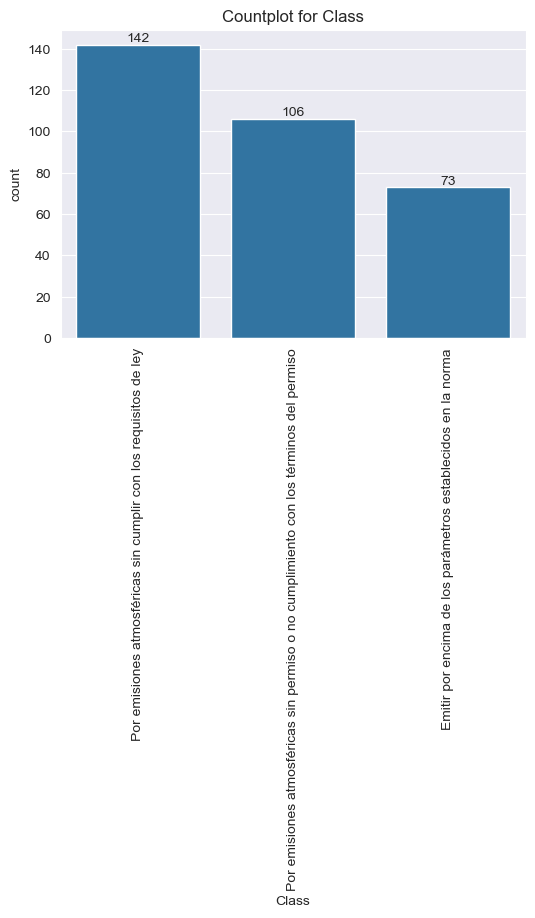

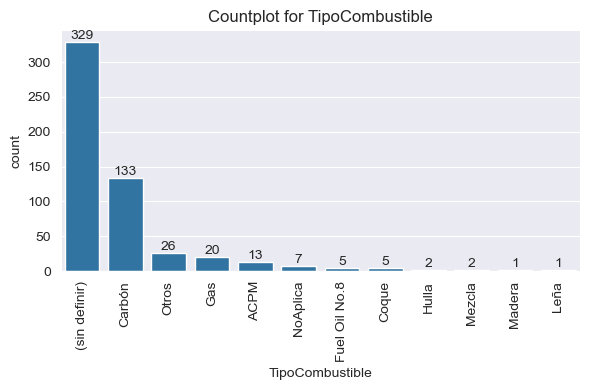

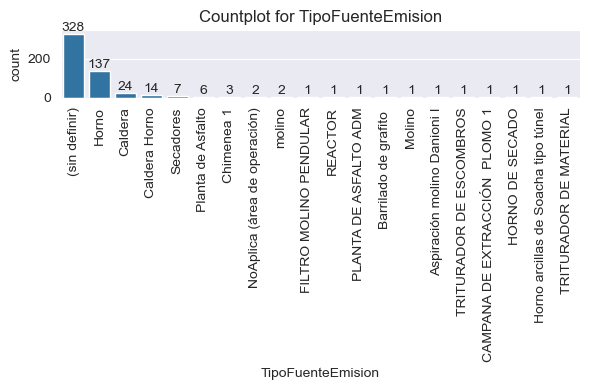

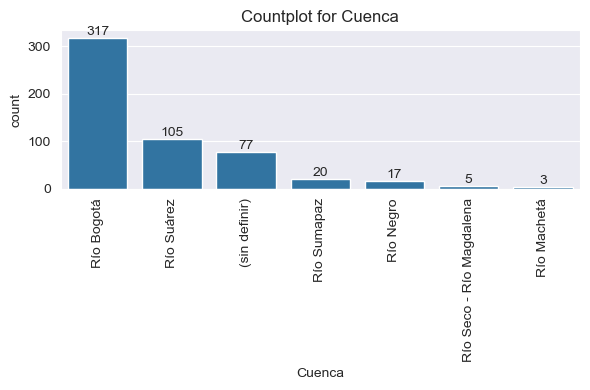

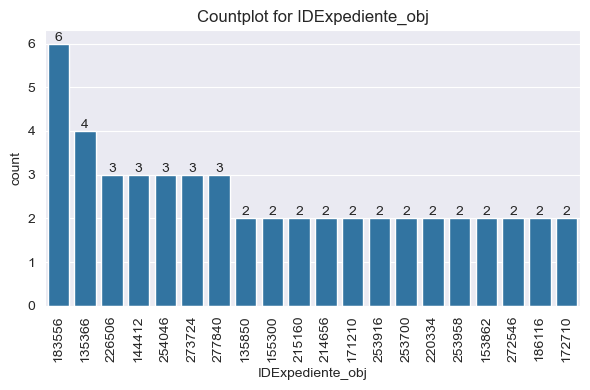

In [28]:
for col in non_numeric_attributes:
    # Tomar los 20 valores más frecuentes
    top_values = df[col].value_counts().head(20).index
    df_top = df[df[col].isin(top_values)]

    plt.figure(figsize=(6, 4))
    # Ordenar por la frecuencia en el countplot
    ax = sns.countplot(
        data=df_top, 
        x=col, 
        order=df_top[col].value_counts().index
    )

    if col in ['Regional', 'Municipio', 'Vereda', 'Class', 'TipoCombustible', 'TipoFuenteEmision', 'Cuenca', 'IDExpediente_obj']:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
    
    # Mostrar los valores encima de las barras
    ax.bar_label(ax.containers[0])

    plt.title(f"Countplot for {col}")
    plt.tight_layout()
    plt.show()


**Hallazgos adicionales:**

- Hay varias palabras sin tildes, especialmente cuando se usan mayúsculas
- Hay inconsistencias en la escritura de nombres propios, especialmente por la capitalización y diferentes formas de referirse a un territorio

Se eliminan las variables creadas

In [29]:
df.drop(columns=['IDExpediente_obj'], inplace=True)

## 2. Variables numéricas

Variables numéricas encontradas

In [15]:
numeric_attributes = df.select_dtypes(include=['number']).columns.values
numeric_attributes = [col for col in numeric_attributes if col not in cols_otra_categoria]
pd.DataFrame(numeric_attributes, columns=['Numeric Attributes'])

,Numeric Attributes
0,Precio Solicitado
1,Área
2,Piso
3,Garajes
4,Ascensores
5,Antiguedad (Años)


Conteo de filas, promedio, desviación estándar, valores mínimo y máximo junto a los cuartiles

In [16]:
df[numeric_attributes].describe()

,Precio Solicitado,Área,Piso,Garajes,Ascensores,Antiguedad (Años)
count,9.983000e+03,9983.000000,9983.000000,9920.0,9901.0,9814.0
mean,2.217953e+08,60.636182,6.120605,0.522379,0.713059,13.572753
std,1.097838e+08,15.920600,24.845918,0.54118,0.736892,76.032397
min,1.200000e+02,1.000000,-3.000000,0.0,0.0,0.0
25%,1.450000e+08,50.000000,3.000000,0.0,0.0,5.0
50%,1.900000e+08,58.000000,4.000000,1.0,1.0,9.0
75%,2.800000e+08,68.000000,7.000000,1.0,1.0,15.0
max,1.800000e+09,300.000000,2204.000000,4.0,4.0,2021.0


**Hallazgos:**

- El _ varía entre _ y _
- El 75 % de _ tiene un _ o inferior a _
- No obstante, no tiene sentido _

Visualización de esta información con diagramas de caja

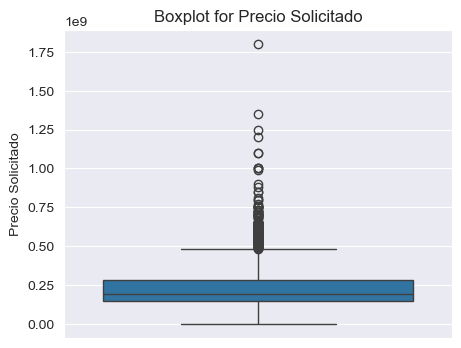

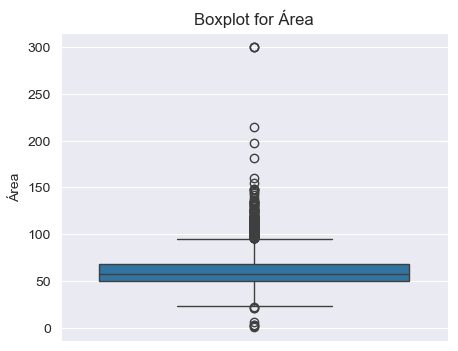

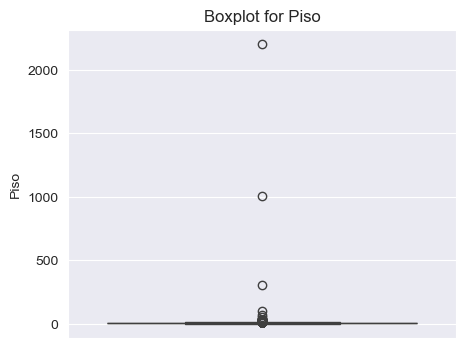

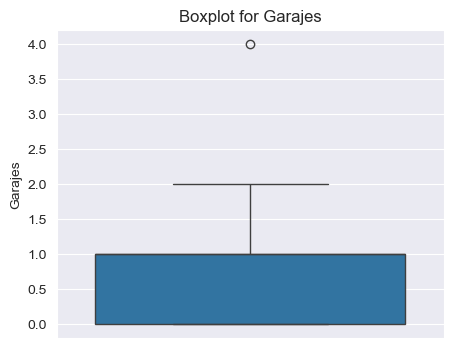

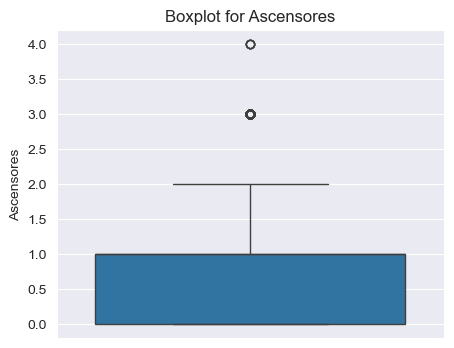

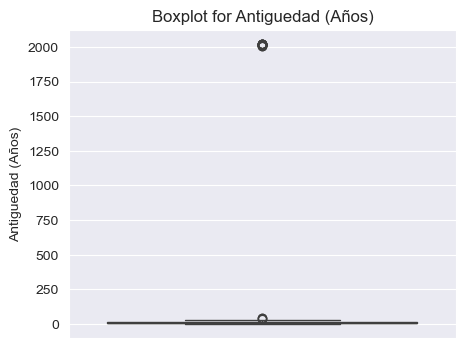

In [17]:
for col in numeric_attributes:
    plt.figure(figsize=(5,4))
    ax = sns.boxplot(data=df[col])
    ax.set_title(f"Boxplot for {col}")
    plt.xticks(rotation=45)
    plt.show()

**Hallazgos adicionales:**

- 

Histogramas para visualizar la distribución de cada columna

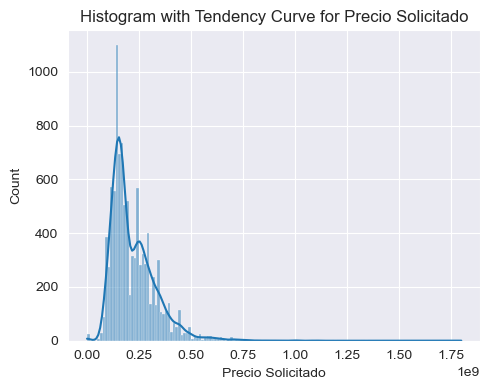

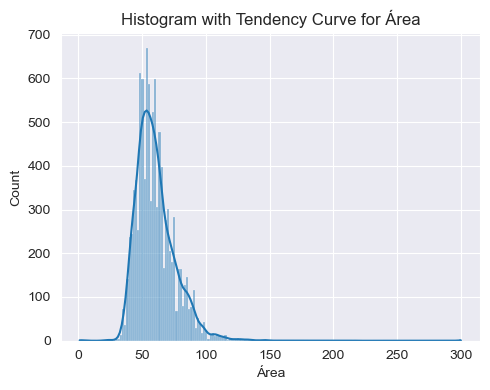

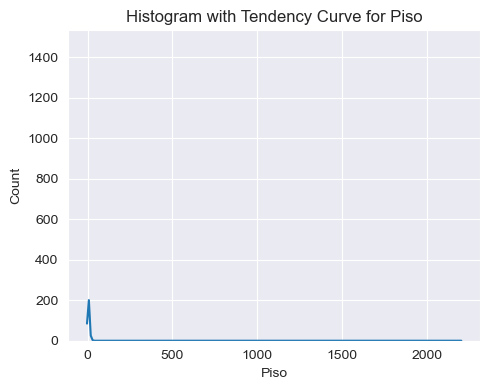

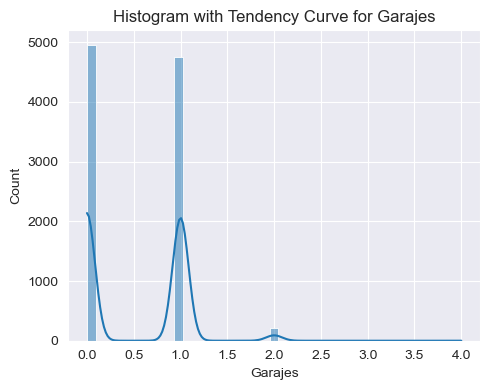

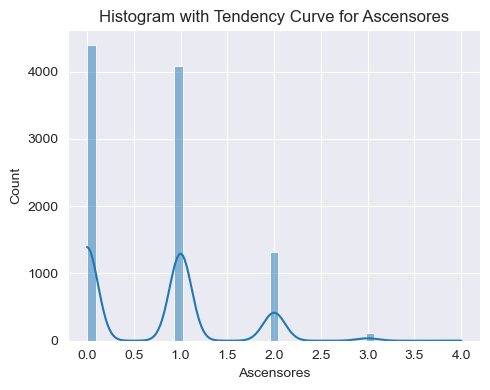

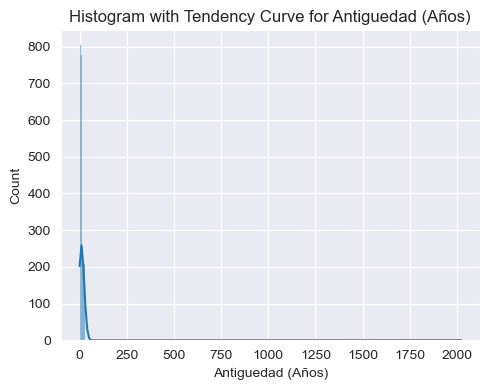

In [18]:
for col in df[numeric_attributes]:
    plt.figure(figsize=(5,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram with Tendency Curve for {col}")
    plt.tight_layout()
    plt.show()

**Hallazgos adicionales:**

- 

## 3. Calidad de datos

### 3.1. Completitud

**Resumen:** 

**Valores de nulos por columna:** Se cuentan los nulos para todas las columnas

In [19]:
incompleteness_percentages =  (100 * df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
pd.DataFrame({
    "Attribute": incompleteness_percentages.index,
    "Completeness (%)": 100 - incompleteness_percentages.values
})

,Attribute,Completeness (%)
0,Lote Id,96.814585
1,Antiguedad (Años),98.307122
2,Ascensores,99.178604
3,Garajes,99.368927
4,Zona,99.669438
5,Ciudad,99.689472
6,Estrato,99.759591
7,Nombre Contacto,99.779625
8,Tipo Inmueble,99.889813
9,Id,100.000000


**Hallazgos:**

- 

**Valores de nulos por fila:** Se cuenta el número de columnas que cada fila tiene como nulo

In [20]:
df_result = df.copy()
df_result['Columnas faltantes'] = df_result.isna().sum(axis=1)
resumen = df_result['Columnas faltantes'].value_counts().sort_index().reset_index()
resumen.columns = ['Columnas faltantes', 'Número de ocurrencias']
resumen['Porcentaje (%)'] = (resumen['Número de ocurrencias'] / len(df_result) * 100).round(2)
resumen

,Columnas faltantes,Número de ocurrencias,Porcentaje (%)
0,0,9472,94.88
1,1,387,3.88
2,2,61,0.61
3,3,31,0.31
4,4,10,0.10
5,5,21,0.21
6,6,1,0.01


**Hallazgos:**

- 

**Valores inadecuados en las variables categóricas:** Gracias al perfilamiento de variables categóricas, se identifican los siguientes problemas de incompletitud más allá de los nulos. Ciertos problemas pueden presentarse en las mismas filas:



In [ ]:
df[df[''] == '']

,Id,Fuente,Ciudad,Zona,Estrato,Lote Id,Tipo Inmueble,Nombre Contacto,Telefono Contacto,Precio Solicitado,Área,Piso,Garajes,Ascensores,Antiguedad (Años)
2457,1271033,Ventana,Valle de Aburrá,NO FOUND,4,<NA>,apartamento,Jenny,******84015,430000000,99,4,1,1,<NA>


### 3.2. Unicidad

**Resumen:** 

Cantidad de filas duplicadas

In [25]:
total_duplicate_rows = df.duplicated().sum()
duplicate_rows_percentage = 100.0 * total_duplicate_rows / df.shape[0]
print(f"{total_duplicate_rows} duplicate rows ({duplicate_rows_percentage:.2f}%)")

0 duplicate rows (0.00%)


Cantidad de filas duplicadas sin considerar columna identificadora única `Id`

In [26]:
df_without_id = df.drop(columns=['Id'])
total_duplicate_rows = df_without_id.duplicated().sum()
duplicate_rows_percentage = 100.0 * total_duplicate_rows / df.shape[0]
print(f"{total_duplicate_rows} duplicate rows ({duplicate_rows_percentage:.2f}%)")

71 duplicate rows (0.71%)


**Hallazgos:**

- 

Cantidad de valores duplicados por cada columna

In [28]:
duplicate_counts = []
duplicate_percentages = []

for col in df.columns:
    duplicates = df.shape[0] - df[col].nunique()
    duplicate_counts.append(duplicates)
    duplicate_percentages.append((duplicates / df.shape[0]) * 100)

duplicates_df = pd.DataFrame({
    "Column": df.columns,
    "Duplicate Count": duplicate_counts,
    "Duplicate Percentage": duplicate_percentages
}).sort_values(by="Duplicate Count", ascending=False).reset_index(drop=True)

duplicates_df

,Column,Duplicate Count,Duplicate Percentage
0,Fuente,9981,99.979966
1,Ciudad,9980,99.969949
2,Tipo Inmueble,9980,99.969949
3,Garajes,9979,99.959932
4,Ascensores,9978,99.949915
5,Estrato,9977,99.939898
6,Piso,9945,99.619353
7,Antiguedad (Años),9941,99.579285
8,Zona,9885,99.018331
9,Área,9855,98.717820


**Hallazgos:**

- 

### 3.3. Consistencia

**Resumen:** 

**Consistencia semántica:** 

**Consistencia de la presentación de variables categóricas:** Gracias al perfilamiento de variables categóricas, podemos evidenciar que variables como _ están escritas de forma inconsistente: algunas totalmente en mayúsculas, otras en minúsculas, otras con mayúscula inicial, entre otras variaciones. 

A continuación, se evidencian todos los tipos de capitalización en las variables mencionadas:

In [ ]:
def detect_casing(text: str) -> str:
    letters = re.findall(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]", str(text))
    if not letters:
        return "Other"
    
    word = "".join(letters)

    if word.isupper():
        return "UPPERCASE"
    elif word.islower():
        return "lowercase"
    elif word[0].isupper() and word[1:].islower():
        return "Capitalized"
    else:
        return "Other"

def casing_summary_df(df: pd.DataFrame) -> pd.DataFrame:
    text_columns = df.select_dtypes(include=["object", "string"]).columns
    results = {}

    for col in text_columns:
        casing_counts = df[col].dropna().apply(detect_casing).value_counts()
        casing_percent = (casing_counts / casing_counts.sum() * 100).round(2)
        results[col] = casing_percent

    summary_df = pd.DataFrame(results).T.fillna(0)
    return summary_df

print("Porcentajes de diferentes tipos de capitalización en variables categóricas:")
casing_summary_df(df[[]])


Porcentajes de diferentes tipos de capitalización en variables categóricas:


,Capitalized,Other,UPPERCASE,lowercase
Fuente,50.15,0.00,49.85,0.00
Zona,3.72,0.00,84.09,12.19
Tipo Inmueble,0.01,0.00,0.00,99.99
Nombre Contacto,75.39,0.79,9.81,14.00


**Hallazgos:**

- 

**Consistencia a través de agrupaciones de características:** Se pueden explorar diferentes agrupaciones en búsqueda de inconsistencias

- **Inconsistencia entre estrato y precio:** Se agrupa por `Estrato` para validar el `Precio Solicitado`, evidenciando que los estratos 2, 3 y 4 tienen valores mínimos no acordes (120, 155 y 200 respectivamente). Esto corresponde con los outliers identificados anteriormente en `Precio Solicitado`

In [30]:
df.groupby("Estrato")["Precio Solicitado"].describe()


,count,mean,std,min,25%,50%,75%,max
Estrato,,,,,,,,
1,36.0,1.189306e+08,2.857525e+07,80000000.0,100000000.0,118000000.0,130000000.0,2.500000e+08
2,1684.0,1.363030e+08,3.105137e+07,120.0,120000000.0,135000000.0,150000000.0,3.350000e+08
3,4822.0,1.900837e+08,7.428438e+07,155.0,145000000.0,175000000.0,230000000.0,1.800000e+09
4,2859.0,2.938878e+08,1.003453e+08,200.0,230000000.0,280000000.0,350000000.0,8.500000e+08
5,496.0,3.796873e+08,1.553909e+08,67000000.0,270000000.0,340000000.0,460000000.0,1.350000e+09
6,62.0,4.628226e+08,1.940431e+08,190000000.0,330000000.0,425000000.0,575000000.0,1.100000e+09


- **Consistencia entre _:** Se agrupa por _, sin evidenciar relaciones anómalas

In [ ]:
print_table(df.groupby([]).size().reset_index(name="Count"))

### 3.4. Validez

**Resumen:** 

**Rangos y outliers:** Como se pudo ver en el perfilamiento de variables numéricas, hay problemas en el rango y los outliers de las siguientes columnas. Para tener más detalles, veamos los percentiles:

In [35]:
percentiles = df[numeric_attributes].quantile([0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0])
percentiles.index = [f"{int(p*100)}%" for p in percentiles.index]
percentiles

,Precio Solicitado,Área,Piso,Garajes,Ascensores,Antiguedad (Años)
0%,1.200000e+02,1.0,-3.0,0,0,0
1%,8.200000e+07,36.0,1.0,0,0,1
5%,1.000000e+08,41.0,1.0,0,0,2
10%,1.200000e+08,44.0,1.0,0,0,3
20%,1.400000e+08,48.0,2.0,0,0,5
30%,1.500000e+08,52.0,3.0,0,0,6
40%,1.700000e+08,55.0,4.0,0,0,7
50%,1.900000e+08,58.0,4.0,1,1,9
60%,2.300000e+08,61.0,5.0,1,1,11
70%,2.600000e+08,65.0,6.0,1,1,13


**Hallazgos:**

- 

Teniendo en cuenta el análisis de percentiles, el perfilamiento de variables numéricas y el contexto colombiano, se proponen los siguientes puntos de corte para identificar ítems inválidos.

- Los _ con ``  son inválidos

In [ ]:
df_menor_precio = df[df[''] < 1]
print(f": {len(df_menor_precio)} ({(len(df_menor_precio)/len(df))*100:.2f}%)")
df_menor_precio

Filas con precio menor a 1.000 COP: 13 (0.13%)


,Id,Fuente,Ciudad,Zona,Estrato,Lote Id,Tipo Inmueble,Nombre Contacto,Telefono Contacto,Precio Solicitado,Área,Piso,Garajes,Ascensores,Antiguedad (Años)
48,1230589,WEB,Bogotá,TIBABUYES,3,221121,apartamento,Gerardo,******88208,155,52,4,0,2,4
57,1230798,WEB,Bogotá,EL RINCON,3,963864,apartamento,hernando,******56665,234,66,8,1,2,2
118,1233270,WEB,Bogotá,SUBA,3,615396,apartamento,Mónica,******62792,240,73,5,1,0,12
123,1233376,WEB,Bogotá,LAS MARGARITAS,2,875817,apartamento,Maria,******56956,135,50,5,0,0,8
182,1234565,WEB,Bogotá,KENNEDY CENTRAL,3,788781,apartamento,Ines,******18676,180,64,3,0,0,27
188,1234637,WEB,Bogotá,SUBA,2,524175,apartamento,Patricia,******24136,190,49,4,0,1,10
200,1234830,WEB,Bogotá,EL RINCON,3,870859,apartamento,Óscar,******22332,180,54,4,0,0,23
229,1235223,WEB,Bogotá,ENGATIVA,2,349863,apartamento,"Sonia,",******76311,140,43,3,0,0,14
262,1235809,WEB,Bogotá,FONTIBON,3,864890,apartamento,Stella,******45543,220,59,4,1,0,25
286,1236187,WEB,Bogotá,BOSA OCCIDENTAL,2,171369,apartamento,Juan,******89150,120,49,4,0,1,7


## 4.  Análisis adicionales

Se puede efectuar un Pandas Profiling para encontrar más información

En especial, son de gran interés las correlaciones y las interacciones entre variables

In [ ]:
reporte = ProfileReport(df)
reporte.to_file("archivos_generados/Reporte perfilamiento - Dataset 2 Original.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 49.75it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Hallazgos:**

Valores faltantes:

- Un _% de las celdas están vacías

Características de las variables:

- 

Correlaciones:

-  está altamente correlacionado con `` (0.) y `` (0.)
